In [9]:
using ramnet
using ramnet.Models: predict_response, BleachingDiscriminator, predict_bleached_response, predict_bleached
using ramnet.Utils: stack, accuracy, ambiguity
using Images
using MLDatasets
using BenchmarkTools

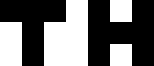

In [2]:
T = Bool[0 0 0; 1 0 1; 1 0 1]
H = Bool[0 1 0; 0 0 0; 0 1 0]

mosaicview(Gray.(T), Gray.(H); nrow=1, npad=1, fillvalue=1)

In [3]:
X, y = stack(vec(T), vec(H)), ["T", "H"]

model = MultiDiscriminatorClassifier{String}(9, 3; seed=1)

train!(model, X, y)

In [4]:
predict(model, X)

2-element Array{String,1}:
 "T"
 "H"

In [5]:
predict_response(model, X)

Dict{String,Array{Int64,1}} with 2 entries:
  "T" => [3, 0]
  "H" => [0, 3]

Testing with novel data:

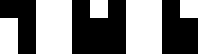

In [6]:
kinda_T = Bool[0 0 1; 1 0 1; 1 0 1]
kinda_H = Bool[0 1 0; 0 0 0; 0 0 0]
kinda_nothing = Bool[1 0 1; 1 0 0; 1 0 0]

mosaicview(Gray.(kinda_T), Gray.(kinda_H), Gray.(kinda_nothing); nrow=1, npad=1, fillvalue=1)

In [7]:
X_test = stack(map(vec, [kinda_T, kinda_H, kinda_nothing])...)

predict(model, X_test)

3-element Array{String,1}:
 "T"
 "H"
 "T"

In [8]:
predict_response(model, X_test)

Dict{String,Array{Int64,1}} with 2 entries:
  "T" => [2, 0, 1]
  "H" => [0, 2, 0]

MNIST:

In [10]:
X_train = permutedims(reshape(MNIST.traintensor(), 784, :)) .> 0.5
y_train = MNIST.trainlabels()

X_test = permutedims(reshape(MNIST.testtensor(), 784, :)) .> 0.5
y_test = MNIST.testlabels()

model_digits = MultiDiscriminatorClassifier{Int64}(784, 28; seed=2)

time_train!(model, X, y) = @btime train!($model, $X, $y)

# time_train!(model_digits, X_train, y_train)
train!(model_digits, X_train, y_train)

In [11]:
time_accuracy(y_pred, y_target) = @btime accuracy($y_pred, $y_target)

time_accuracy (generic function with 1 method)

In [12]:
time_accuracy(predict(model_digits, X_test), y_test)

  5.029 μs (3 allocations: 5.55 KiB)


0.8357

This result is similar to what I get with `wisardpkg` with bleaching **deactivated** but worst then the accuracy when it's activated. Bleaching could be understood as a disambiguation technique, for when there is a tie between discriminators' responses during classification. Before making use of bleaching, it would be interesting to measure the frequency of draws in the classfication of this test set:

In [13]:
ambiguity(values(predict_response(model_digits, X_test))...)

0.1479

More then **14%** of the test images are tying and we should assume that a good number of them are being misclassified.

The models used so far have at their core RAM neurons that address single-bit words. If instead we make use of neurons that address multi-bit words, we could associate to every possible input pattern to that neuron not only its occurance in the dataset but also its frequency. These frequencies give us an extra dimension in comparing discriminators and may be used as a disambiguation mechanism. One way in which the frequencies are is by defining a bleaching threshold **b** for the neuron. In such a scheme an input pattern activates the neuron only with its observed frequency during training was greater than **b**. Notice that we can achieve the same activation behavior  of the previously seen neurons by setting **b** to zero.

`BleachingDiscriminator` is one that makes use of `AccNode` neurons, where each address is associated with a counter. Classifiers that make use of this discriminator may specify a bleaching threshold as explained above during prediction. For example, training such a bleaching-enabled classifier with the MNIST dataset and using a bleaching threshold of 4, we can attain a considerable gain in accuracy:

In [14]:
model_bleaching = MultiDiscriminatorClassifier{Int64,BleachingDiscriminator}(784, 28; seed=2)

train!(model_bleaching, X_train, y_train)

In [15]:
time_accuracy(predict(model_bleaching, X_test; b=4), y_test)

  5.078 μs (3 allocations: 5.55 KiB)


0.9145

We can also see that the ambiguity went down:

In [16]:
ambiguity(values(predict_response(model_bleaching, X_test; b=4))...)

0.0453

What we have done just now was manually setting a bleaching threshold that was used for all test patterns. However, different patterns may require different levels of bleaching. Additionally, is it really necessary for us to select it manually? Truly, we can achieve a better classification performance if we select thresholds on a case by case basis and we can employ a simple and automatic selection strategy instead of doing it by hand:

In [17]:
time_accuracy(predict_bleached(model_bleaching, X_test), y_test)

  5.077 μs (3 allocations: 5.55 KiB)


0.921

In [19]:
ambiguity(values(predict_bleached_response(model_bleaching, X_test))...)

LoadError: MethodError: no method matching predict_bleached_response(::MultiDiscriminatorClassifier{Int64,Discriminator{ramnet.Models.Nodes.AccNode}}, ::BitArray{2})
Closest candidates are:
  predict_bleached_response(::MultiDiscriminatorClassifier{C,Discriminator{ramnet.Models.Nodes.AccNode}}, !Matched::T) where {T<:AbstractArray{Bool,1}, C} at /home/rkatopodis/Dissertation/Code/ramnet/src/Models/MultiDiscriminatorClassifier.jl:104